# Notebook A: Experimental Growth Parameter Calculations

This Jupyter notebook is dedicated to the analysis and calculation of growth parameters for the olegenous yeast, Y. lipolytica, when grown with glucose, glycerol and oleic acid. 


### Objective
The objective of this analysis is to provide a clear and quantifiable understanding of the how of the growth rates, yield coefficients, and substrate uptake rates were calculated. This is crucial for providing constraints for the later genome scale model analysis.

### Important Functions
`get_trial_growth_parameters`
This function calculates growth parameters for a single trial. It computes the growth rate, yield coefficient, and substrate uptake rate for a given trial number.

`get_average_growth_parameters`
This function computes the average growth parameters across multiple trials. This function leverages the get_trial_growth_parameters function for each trial and then averages the results.

### A note about oleic acid yield
Due to difficulties in measuring the partially insoluable oleic acid, the oleic acid yield was determined based on the yields of glucose and glycerol. The process involved normalizing glucose and glycerol yields to a single carbon basis, averaging these values, and extrapolating to oleic acid's 18 carbons. The standard deviation was calculated in the same way

### Load imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

### Define a function for calculating growth parameters

In [2]:
def get_trial_growth_parameters(
    growth_df=None, 
    trial_num=None, 
    molar_mass=None,
    substrate=None
):
    # define the conversion factor from OD to g/L
    yarrowia_g_per_OD = 0.2966

    substrate_column = f'{substrate}_g/l_{trial_num}'
    biomass_column = f'yarrowia_OD_{trial_num}'

    time_h = growth_df['time_h'].tolist()
    substrate_g_L = growth_df[substrate_column].tolist()
    substrate_mmols_L = [1000 * g / molar_mass for g in substrate_g_L]
    starting_substrate = substrate_mmols_L[0]
    final_substrate = substrate_mmols_L[-1]

    yarrowia_OD = growth_df[biomass_column].tolist()
    yarrowia_g_L = [y * yarrowia_g_per_OD for y in yarrowia_OD]
    starting_biomass = yarrowia_g_L[0]
    final_biomass = yarrowia_g_L[-1]

    growth_rate, _, _, _, _ = stats.linregress(time_h, [math.log(val) for val in yarrowia_g_L])
    fitted_biomass_conc = [starting_biomass * math.exp(growth_rate * time) for time in time_h]
    fitted_biomass_produced = [biomass_conc - starting_biomass for biomass_conc in fitted_biomass_conc]

    delta_X = final_biomass - starting_biomass
    delta_S = starting_substrate - final_substrate
    yield_coefficient = delta_X / delta_S
    substrate_uptake_rate = (1/yield_coefficient) * growth_rate

    fitted_substrate_conc = [starting_substrate - (1 / yield_coefficient) * biomass_produced 
                                for biomass_produced in fitted_biomass_produced]
    
    # define a plotting area with two subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

    # Set the background color of the figure to white
    fig.patch.set_facecolor('white')

    for ax in axes:
        # Set the background color of the plots to white
        ax.set_facecolor('white')
        
        # Set the color of the spines (borders) to black
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
        
        # Set the color of the titles, labels, ticks, and tick labels to black
        ax.title.set_color('black')
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='both', colors='black')

    # plot biomass data on the left
    axes[0].set_title('Biomass Growth', fontsize=16)
    axes[0].set_xlabel('Time (hr)', fontsize=14)
    axes[0].set_ylabel('Biomass (g/L)', fontsize=14)

    # plot experimental biomass concentration data points
    axes[0].plot(time_h, yarrowia_g_L, 'o', color='red')
    # plot fitted biomass concentration curve
    axes[0].plot(time_h, fitted_biomass_conc, '-', color='red')

    # plot substrate consumption data on the right
    axes[1].set_title(f'{substrate.capitalize()} Consumption', fontsize=16)
    axes[1].set_ylabel(f'{substrate.capitalize()} (mmol/L)', fontsize=14)
    axes[1].set_xlabel('Time (hr)', fontsize=14)

    # plot experimental substrate concentration data points
    axes[1].plot(time_h, substrate_mmols_L, 'o', color='blue')
    # plot fitted substrate concentration curve
    axes[1].plot(time_h, fitted_substrate_conc, '-', color='blue')

    return growth_rate, yield_coefficient, substrate_uptake_rate

In [3]:
def get_average_growth_parameters(growth_df=None, substrate=None, molar_mass=None):
    growth_rates = []
    yield_coefficients = [] 
    substrate_uptake_rates = []

    # loop over trials
    for trial_num in ['1', '2', '3']:
        
        # get the growth parameters for each trial
        growth_rate, yield_coefficient, substrate_uptake_rate = get_trial_growth_parameters(
            growth_df=growth_df, 
            trial_num=trial_num, 
            molar_mass=molar_mass, 
            substrate=substrate
        )

        print(f'Trial {trial_num}:')
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coefficient:.3f} g biomass/mmol {substrate}')
        print(f'substrate consumption rate = {substrate_uptake_rate:.3f} mmol {substrate}/gram biomass * hr')
        print()

        # append the growth parameters to the lists
        growth_rates.append(growth_rate)
        yield_coefficients.append(yield_coefficient)
        substrate_uptake_rates.append(substrate_uptake_rate)

    # calculate the average parameter values
    growth_rate = np.average(growth_rates)
    yield_coefficient = np.average(yield_coefficients)
    substrate_uptake_rate = np.average(substrate_uptake_rates)

    # calculate the standard deviation of parameter values
    growth_rate_std = np.std(growth_rates)
    yield_coefficient_std = np.std(yield_coefficients)
    substrate_uptake_rate_std = np.std(substrate_uptake_rates)

    # print the growth parameters
    print('Average Growth Parameters:')
    print(f'growth_rate = {growth_rate:.3f} ± {growth_rate_std:.3f} hr-1')
    print(f'yield coefficient = {yield_coefficient:.3f} ± {yield_coefficient_std:.3f} g biomass/mmol {substrate}')
    print(f'substrate consumption rate = {substrate_uptake_rate:.3f} ± {substrate_uptake_rate_std:.3f} mmol {substrate}/gram biomass * hr') 

    return {
        'growth_rate': growth_rate,
        'growth_rate_std': growth_rate_std,
        'yield_coefficient': yield_coefficient,
        'yield_coefficient_std': yield_coefficient_std,
        'substrate_uptake_rate': substrate_uptake_rate,
        'substrate_uptake_rate_std': substrate_uptake_rate_std
    }

### Load glucose growth curve data

In [4]:
# load data/growth_curves/glucose_growth_data.csv
glucose_growth_df = pd.read_csv('../data/growth_curves/glucose_growth_data.csv')

glucose_growth_df

,time_h,glucose_g/l_1,glucose_g/l_2,glucose_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0,1.680009,1.712100,1.908116,0.0788,0.0788,0.0788
1,5,1.752865,1.983573,1.939340,0.1621,0.1652,0.1589
2,8,1.220327,1.311396,1.222061,0.4818,0.4578,0.5407
3,11,1.091963,1.187368,0.882937,1.2770,1.3020,1.2850
4,15,0.058111,0.051172,0.047703,3.3720,3.6810,3.8010


### Get glucose growth parameters

Trial 1:
growth_rate = 0.262 hr-1
yield coefficient = 0.108 g biomass/mmol glucose
substrate consumption rate = 2.417 mmol glucose/gram biomass * hr

Trial 2:
growth_rate = 0.267 hr-1
yield coefficient = 0.116 g biomass/mmol glucose
substrate consumption rate = 2.304 mmol glucose/gram biomass * hr

Trial 3:
growth_rate = 0.270 hr-1
yield coefficient = 0.107 g biomass/mmol glucose
substrate consumption rate = 2.522 mmol glucose/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.266 ± 0.003 hr-1
yield coefficient = 0.110 ± 0.004 g biomass/mmol glucose
substrate consumption rate = 2.414 ± 0.089 mmol glucose/gram biomass * hr


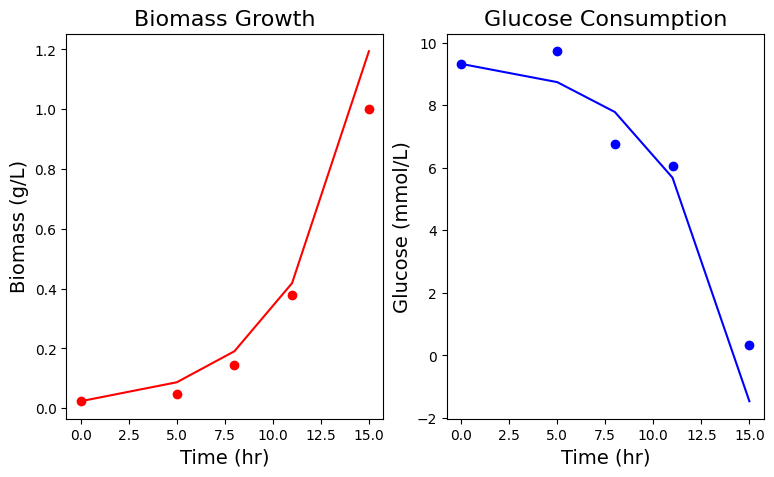

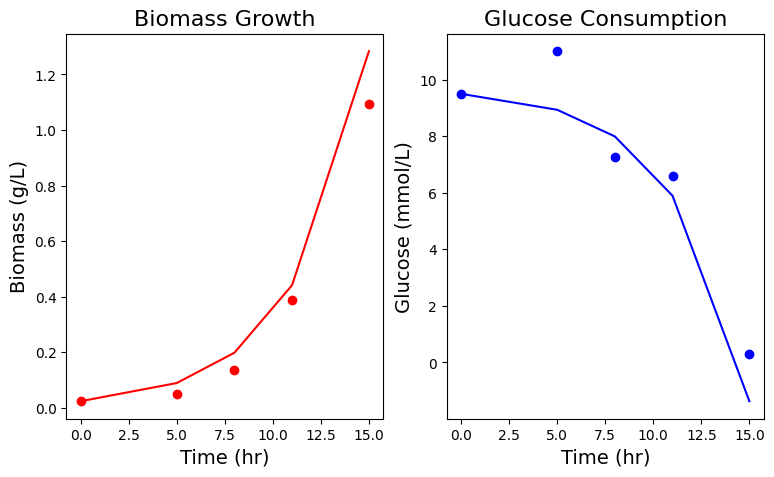

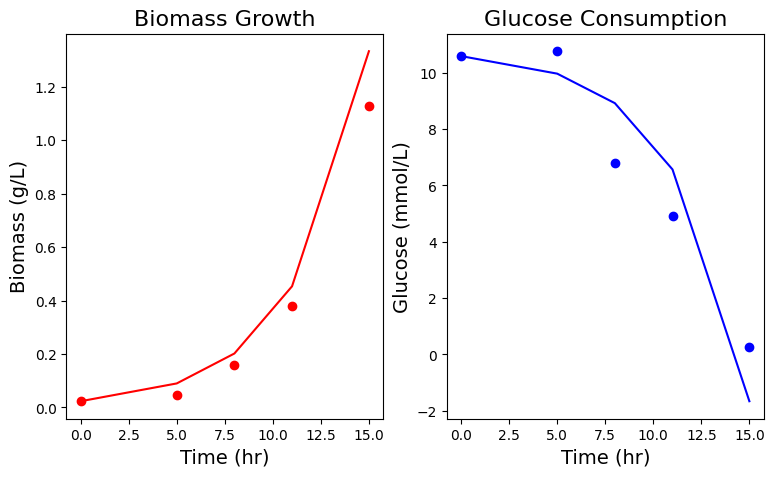

In [5]:
glucose_growth_parameters = get_average_growth_parameters(growth_df=glucose_growth_df, substrate='glucose', molar_mass=180.16)

### Load glycerol data

In [6]:
# load data/growth_curves/glycerol_growth_data.csv
glycerol_growth_df = pd.read_csv('../data/growth_curves/glycerol_growth_data.csv')

glycerol_growth_df

,time_h,glycerol_g/l_1,glycerol_g/l_2,glycerol_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0,1.389,1.812,1.998,0.0785,0.0785,0.0785
1,5,2.678,1.736,2.263,0.2847,0.3147,0.2809
2,8,1.792,1.626,1.553,1.3272,1.4934,1.3482
3,11,0.038,0.022,0.008,3.6400,3.6300,3.6945


### Calculate glycerol parameters

Trial 1:
growth_rate = 0.357 hr-1
yield coefficient = 0.072 g biomass/mmol glycerol
substrate consumption rate = 4.956 mmol glycerol/gram biomass * hr

Trial 2:
growth_rate = 0.359 hr-1
yield coefficient = 0.054 g biomass/mmol glycerol
substrate consumption rate = 6.618 mmol glycerol/gram biomass * hr

Trial 3:
growth_rate = 0.359 hr-1
yield coefficient = 0.050 g biomass/mmol glycerol
substrate consumption rate = 7.226 mmol glycerol/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.358 ± 0.001 hr-1
yield coefficient = 0.059 ± 0.010 g biomass/mmol glycerol
substrate consumption rate = 6.267 ± 0.960 mmol glycerol/gram biomass * hr


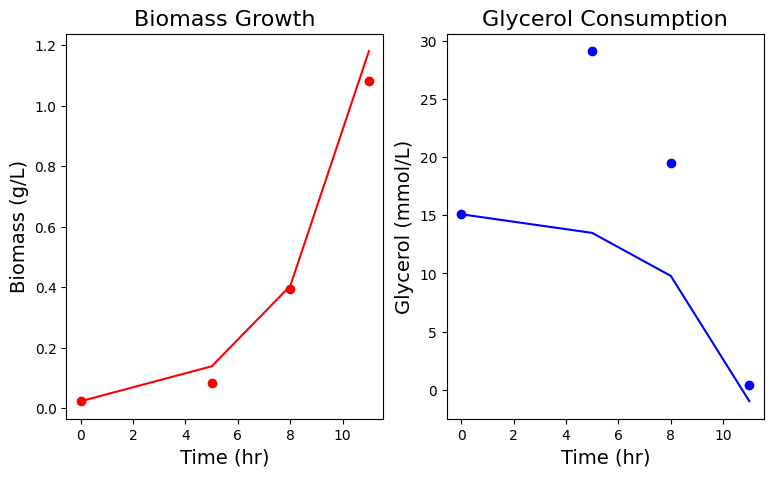

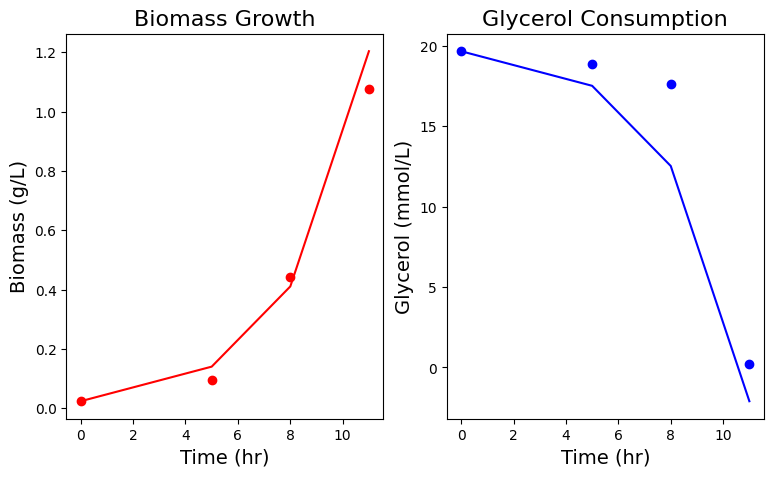

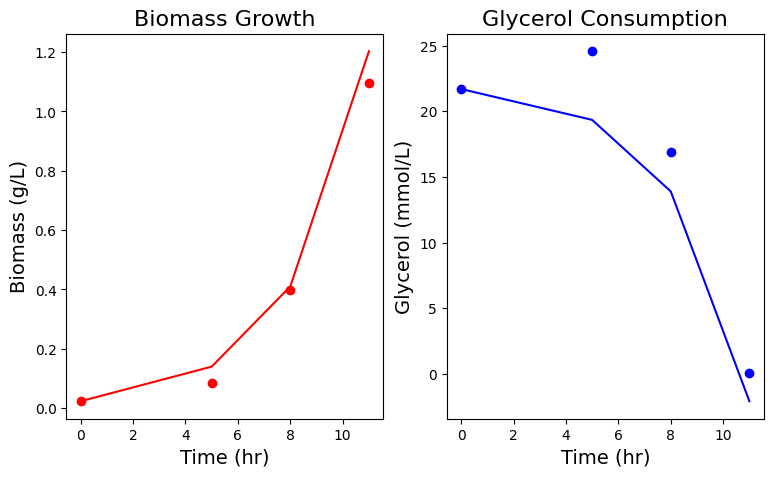

In [7]:
glycerol_growth_parameters = get_average_growth_parameters(growth_df=glycerol_growth_df, substrate='glycerol', molar_mass=92.09)

### Load oleic acid growth curve data

In [8]:
oleic_acid_growth_df = pd.read_csv('../data/growth_curves/oleic_acid_growth_data.csv')

oleic_acid_growth_df

,time_h,oleic_acid_g/l_1,oleic_acid_g/l_2,oleic_acid_g/l_3,yarrowia_OD_1,yarrowia_OD_2,yarrowia_OD_3
0,0.00,NaN,NaN,NaN,0.050,0.050,0.050
1,4.25,NaN,NaN,NaN,0.189,0.184,0.224
2,7.67,NaN,NaN,NaN,0.412,0.420,0.468
3,10.08,NaN,NaN,NaN,0.602,0.742,1.132
4,12.66,NaN,NaN,NaN,1.202,1.492,1.504


### Get oleic acid growth parameters

Trial 1:
growth_rate = 0.244 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Trial 2:
growth_rate = 0.264 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Trial 3:
growth_rate = 0.274 hr-1
yield coefficient = nan g biomass/mmol oleic_acid
substrate consumption rate = nan mmol oleic_acid/gram biomass * hr

Average Growth Parameters:
growth_rate = 0.261 ± 0.012 hr-1
yield coefficient = nan ± nan g biomass/mmol oleic_acid
substrate consumption rate = nan ± nan mmol oleic_acid/gram biomass * hr


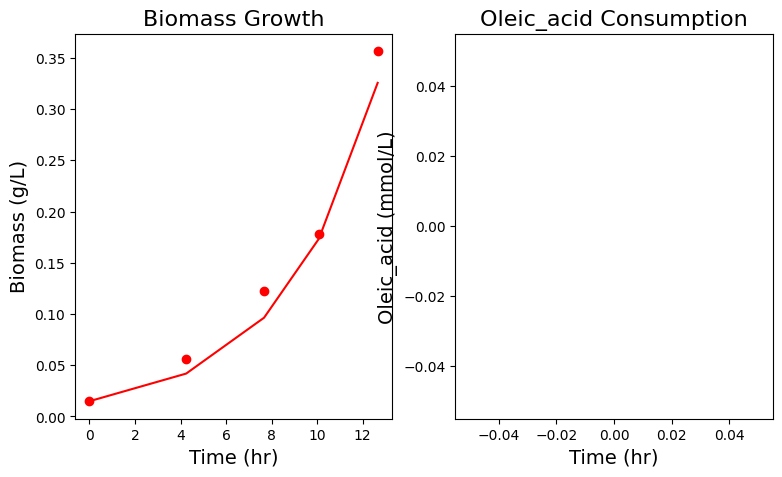

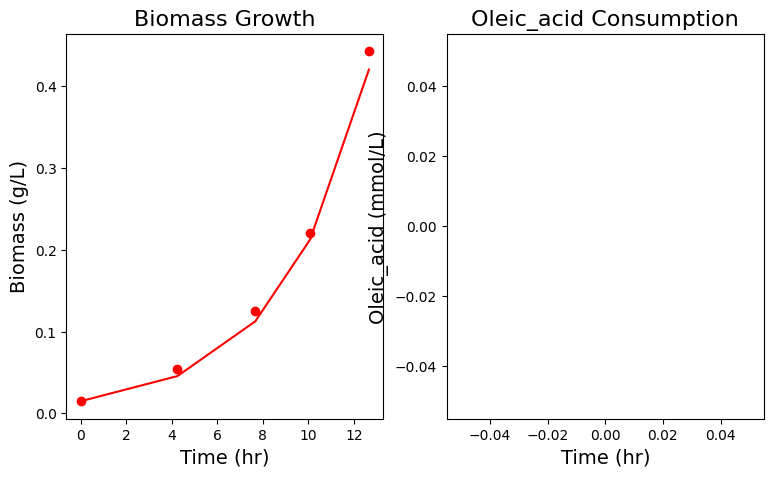

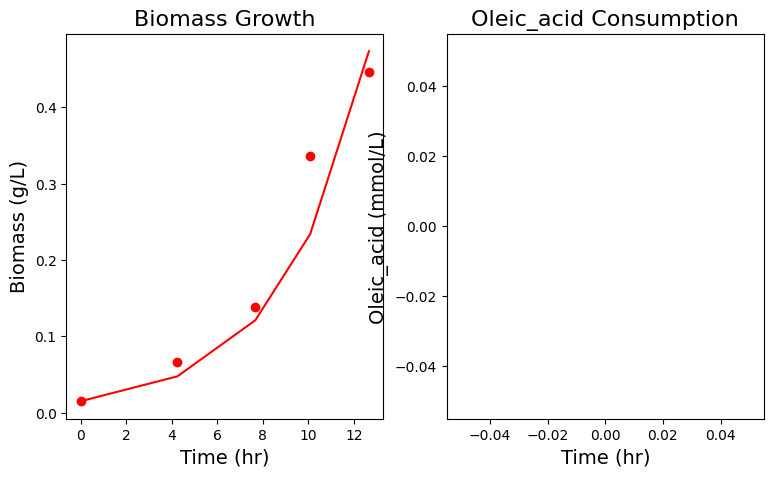

In [9]:
oleic_acid_growth_parameters = get_average_growth_parameters(growth_df=oleic_acid_growth_df, substrate='oleic_acid', molar_mass=282.46)

### Extrapolate glucose and glycerol yields to oleic acid

In [10]:
# get the average yield coefficient normalized to number by carbon atoms (based on yield coefficients of glucose and glycerol)
glucose_yield_coefficient_per_c = glucose_growth_parameters['yield_coefficient'] / 6
glycerol_yield_coefficient_per_c = glycerol_growth_parameters['yield_coefficient'] / 3
average_yield_coefficient_per_c = (glucose_yield_coefficient_per_c + glycerol_yield_coefficient_per_c) / 2

# Get the standard deviation of  oleic acid yield coefficient normalized to number by carbon atoms 
glucose_yield_coefficient_per_c_std = glucose_growth_parameters['yield_coefficient_std'] / 6
glycerol_yield_coefficient_per_c_std = glycerol_growth_parameters['yield_coefficient_std'] / 3

# Calculating pooled standard deviation
average_yield_coefficient_per_c_std = (glucose_yield_coefficient_per_c_std**2 + glycerol_yield_coefficient_per_c_std**2)**0.5 / 2

# extrapolate the average yield coefficient to oleic acid (18 carbons)
oleic_acid_yield_coefficient = average_yield_coefficient_per_c * 18
oleic_acid_yield_coefficient_std = average_yield_coefficient_per_c_std * 18

# add the oleic acid yield coefficient to the growth parameters dictionary
oleic_acid_growth_parameters['yield_coefficient'] = oleic_acid_yield_coefficient
oleic_acid_growth_parameters['yield_coefficient_std'] = oleic_acid_yield_coefficient_std

print(f'oleic acid yield coefficient = {oleic_acid_yield_coefficient:.3f} ± {oleic_acid_yield_coefficient_std:.3f} g biomass/mmol oleic acid')

oleic acid yield coefficient = 0.341 ± 0.030 g biomass/mmol oleic acid


### Calculate oleic acid substrate uptake rate

In [11]:
# calculate the substrate uptake rate
substrate_uptake_rate = oleic_acid_growth_parameters['growth_rate'] / oleic_acid_growth_parameters['yield_coefficient']

# calculate the standard deviation of the substrate uptake rate
partial_mu = 1 / oleic_acid_growth_parameters['yield_coefficient']
partial_Y = -oleic_acid_growth_parameters['growth_rate'] / (oleic_acid_growth_parameters['yield_coefficient'] ** 2)
substrate_uptake_rate_std = ((partial_mu * oleic_acid_growth_parameters['growth_rate_std']) ** 2 + (partial_Y * oleic_acid_growth_parameters['yield_coefficient_std']) ** 2) ** 0.5

# add the substrate uptake rate to the growth parameters dictionary
oleic_acid_growth_parameters['substrate_uptake_rate'] = substrate_uptake_rate
oleic_acid_growth_parameters['substrate_uptake_rate_std'] = substrate_uptake_rate_std

print(f'oleic acid substrate uptake rate = {substrate_uptake_rate:.3f} ± {substrate_uptake_rate_std:.3f} mmol oleic acid/gram biomass * hr')

oleic acid substrate uptake rate = 0.763 ± 0.075 mmol oleic acid/gram biomass * hr


### Save measured biomass yields as a csv

In [12]:
# generate a dataframe of the average growth parameters
average_growth_parameters_df = pd.DataFrame({
    'glucose': glucose_growth_parameters,
    'glycerol': glycerol_growth_parameters,
    'oleic_acid': oleic_acid_growth_parameters
})

# save as a csv
average_growth_parameters_df.to_csv('../results/growth_parameters/growth_parameters.csv')

average_growth_parameters_df


,glucose,glycerol,oleic_acid
growth_rate,0.266298,0.358041,0.260555
growth_rate_std,0.003048,0.000861,0.012321
yield_coefficient,0.110433,0.058610,0.341479
yield_coefficient_std,0.003913,0.009653,0.029548
substrate_uptake_rate,2.414362,6.266590,0.763019
substrate_uptake_rate_std,0.088704,0.959634,0.075240
